In [1]:
!git clone https://github.com/KORALLLL/diffusion.git

Cloning into 'diffusion'...
remote: Enumerating objects: 113, done.
remote: Counting objects: 100% (113/113), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 113 (delta 43), reused 99 (delta 33), pack-reused 0
Receiving objects: 100% (113/113), 686.25 KiB | 17.16 MiB/s, done.
Resolving deltas: 100% (43/43), done.


In [2]:
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 6.5 MB/s eta 0:00:00


In [1]:
import pickle, gzip, math, os, time, shutil, torch, matplotlib as mpl, numpy as np, matplotlib.pyplot as plt 
import sys, gc, traceback
import fastcore.all as fc
from fastcore.test import test_close
from collections.abc import Mapping
from pathlib import Path 
from operator import attrgetter, itemgetter
from functools import partial
from copy import copy
from contextlib import contextmanager
import logging

import torchvision.transforms.functional as TF, torch.nn.functional as F
from torch import tensor, nn, optim 
from torch.utils.data import DataLoader, default_collate
from torch.nn import init
from torcheval.metrics import MulticlassAccuracy
from datasets import load_dataset, load_dataset_builder

# sys.path.append(os.path.abspath('..'))
# sys.path.append(os.path.abspath('/kaggle/working/diffusion'))


# from diffusion.data_utils import *
# from diffusion.learners import *
# from diffusion.callbacks import *
# from diffusion.metrics import *
# from diffusion.utils import *

/home/korallll/Desktop/diffusion/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)

logging.disable(logging.WARNING)

set_seed(42)

In [5]:
x, y = 'image', 'label'
name = 'fashion_mnist'
dsd = load_dataset(name, trust_remote_code=True)
bs = 1024

@inplace
def transformi(b): b[x] = [TF.to_tensor(o) for o in b[x]]

tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=4)

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [6]:
def conv(input_channels, output_channels, kernel_size=3, act=True):
    res = nn.Conv2d(in_channels=input_channels,
                    out_channels=output_channels,    
                    kernel_size=kernel_size,
                    padding=kernel_size//2
    )
    if act: res = nn.Sequential(res, nn.ReLU())
    return res 

def get_model():
    return nn.Sequential(conv(1,8), conv(8,16), conv(16,32), conv(32,64), conv(64,10, act=False), nn.Flatten()).to('cpu')

In [7]:
lrf_cbs = [DeviceCB(device='cuda:0'), ProgressCB(), LRFinderCB(lr_mult=1.1)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-2, cbs=lrf_cbs)

CancelFitException: 

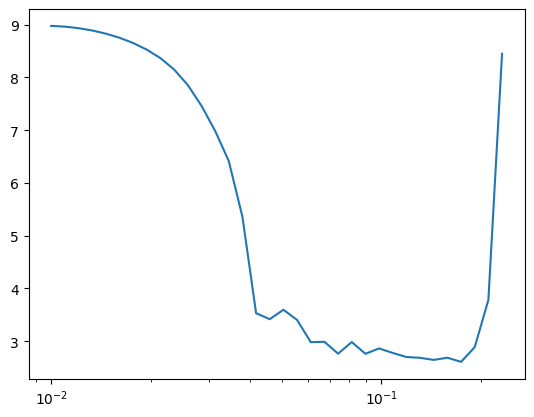

In [8]:
learn.fit(1)

CancelEpochException: 

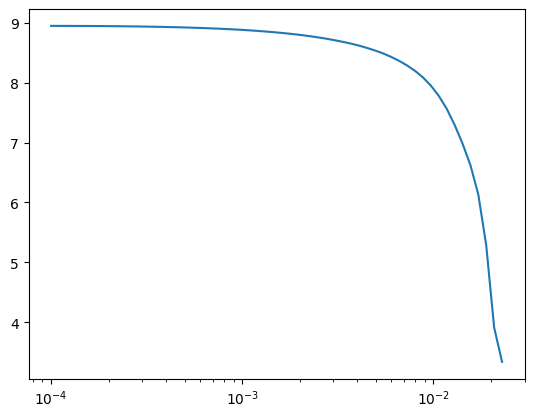

In [24]:
lrf_cbs = [DeviceCB(device='cuda:0'), ProgressCB(), LRFinderCB(lr_mult=1.1)]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=1e-4, cbs=lrf_cbs)
learn.fit(1)

In [8]:
# export
def clean_ipython_hist():
    if not 'get_ipython' in globals(): return
    ip = get_ipython()
    user_ns = ip.user_ns
    ip.displayhook.flush()
    pc = ip.displayhook.prompt_count + 1
    for n in range(1, pc): user_ns.pop('_i'+repr(n), None)
    user_ns.update(dict(_i='',_ii='',_iii=''))
    hm = ip.history_manager
    hm.input_hist_parsed[:] = [''] * pc 
    hm.input_hist_raw[:] = [''] * pc 
    hm._i = hm._ii = hm._iii = hm._i00 = '' 
# clean_ipython_hist()

In [9]:
# export
def clean_tb():
    if hasattr(sys, 'last_traceback'):
        traceback.clear_frames(sys.last_traceback)
        delattr(sys, 'last_traceback')
    if hasattr(sys, 'last_type'): delattr(sys, 'last_type')
    if hasattr(sys, 'last_valye'): delattr(sys, 'last_value')

In [10]:
# export
def clean_mem():
    clean_tb()
    clean_ipython_hist()
    gc.collect()
    torch.cuda.empty_cache()

In [11]:
metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(device='cuda:0'), metrics, ProgressCB(plot=True), astats]
learn = MomentumLearner(get_model(), dls, F.cross_entropy, lr=0.2, cbs=cbs)

In [13]:
next(learn.model.parameters()).device

device(type='cpu')

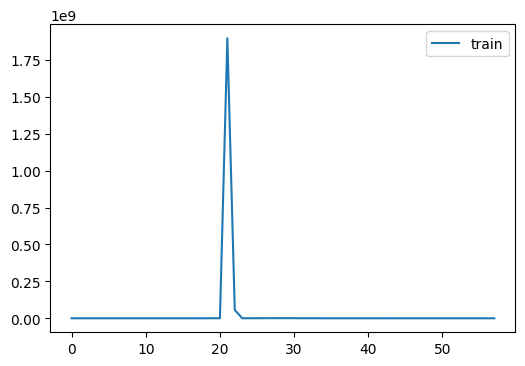

In [40]:
learn.fit(1)

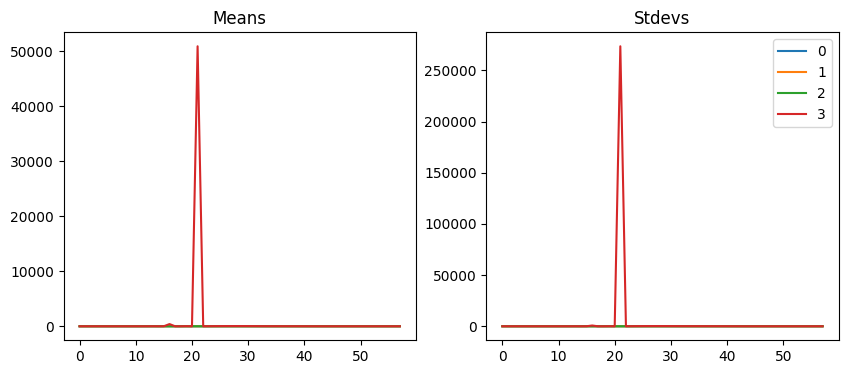

In [41]:
astats.plot_stats()

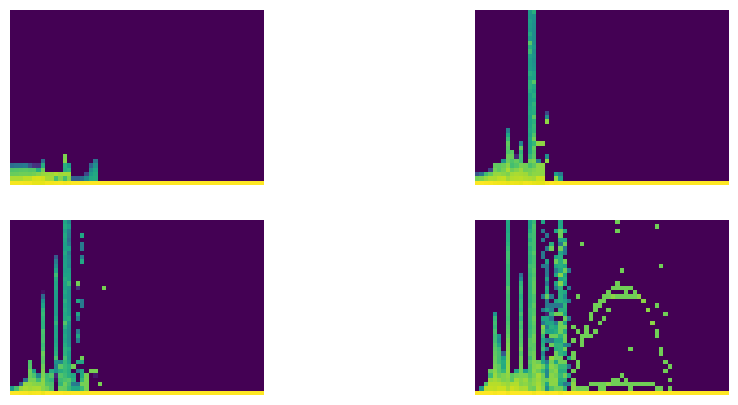

In [42]:
astats.color_dim()

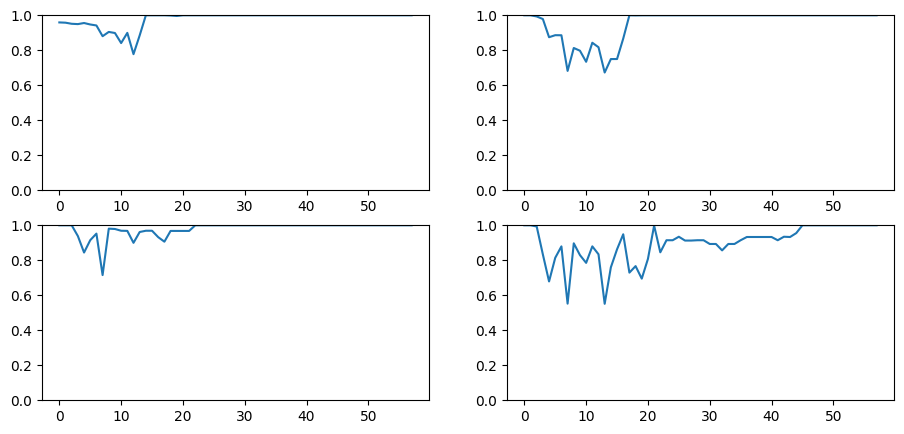

In [43]:
astats.dead_chart()

# Glorot/Xavier init

In [10]:
x = torch.randn(200,100)
for i in range(50): x = x @ torch.randn(100,100)
x[:5, :5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

In [11]:
x = torch.randn(200,100)
for i in range(50): x = x @ (torch.randn(100,100) * 0.01)
x[:5, :5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

In [17]:
x = torch.randn(200,100)
for i in range(100): x = x @ (torch.randn(100,100) * 0.1)
x[:5, :5]

tensor([[ 0.02, -1.51, -2.19, -0.95, -0.36],
        [ 0.48,  0.67,  0.96,  0.35,  0.47],
        [ 0.87,  2.23,  3.14,  0.94,  1.46],
        [ 2.37,  4.70,  6.29,  1.88,  3.18],
        [-0.22,  0.38,  0.20,  0.03,  0.02]])

# BackGround

## Variance and standart deviation

In [18]:
t = torch.tensor([1.,2.,4.,18.])

In [20]:
m = t.mean(); m

tensor(6.25)

In [21]:
(t-m).mean()

tensor(0.)

In [23]:
(t-m).pow(2).mean().sqrt()

tensor(6.87)

In [24]:
(t-m).abs().mean()

tensor(5.88)

In [25]:
(t-m).pow(2).mean(), (t*t).mean() - (m*m)

(tensor(47.19), tensor(47.19))

## Covariance

In [26]:
t

tensor([ 1.,  2.,  4., 18.])

In [27]:
u = t * 2
u *= torch.randn_like(t)/10 + 0.95

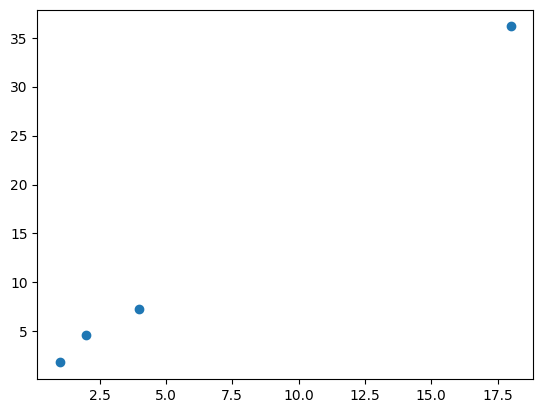

In [28]:
plt.scatter(t,u)

In [29]:
prod = (t-t.mean()) * (u - u.mean()); prod

tensor([ 55.95,  33.23,  11.69, 278.15])

In [30]:
prod.mean()

tensor(94.75)

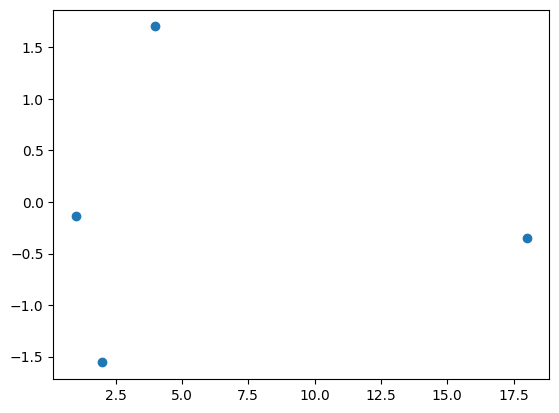

In [31]:
v = torch.randn_like(t)
plt.scatter(t,v)

In [33]:
((t-t.mean())*(v-v.mean())).mean()

tensor(-0.14)

In [32]:
cov = (t*v).mean() - t.mean()*v.mean(); cov

tensor(-0.14)

In [34]:
cov / (t.std() * v.std())

tensor(-0.01)

## Xavier init derivation

In [36]:
x = torch.randn(100)
x.mean(), x.std()

(tensor(0.03), tensor(0.94))

In [37]:
mean, sqr = 0., 0.
for i in range(100):
    x = torch.randn(100)
    a = torch.randn(512, 100)
    y = a @ x
    mean += y.mean().item()
    sqr += y.pow(2).mean().item()
mean/100, sqr/100

(0.053731617256999015, 102.21199272155762)

In [39]:
mean, sqr = 0., 0.
for i in range(10000):
    x = torch.randn(1)
    a = torch.randn(1)
    y = a * x
    mean += y.item()
    sqr += y.pow(2).item()
mean/10000, sqr/10000

(-0.024033848288375088, 1.0092486147237338)

# Kaiming/He init

In [40]:
x = torch.randn(200, 100)
y = torch.randn(200)

In [14]:
from math import sqrt

In [46]:
w1 = torch.randn(100,50) / sqrt(100)
b1 = torch.zeros(50)
w2 = torch.randn(50,1) / sqrt(50)
b2 = torch.zeros(1)

In [47]:
def lin(x,w,b): return x@w + b

In [63]:
ll = lin(x,w1,b1)
ll.mean(), ll.std()

(tensor(0.01), tensor(1.02))

In [15]:
def relu(x): return x.clamp_min(0.)

In [69]:
l2 = relu(ll)
l2.mean(), l2.std()

(tensor(0.42), tensor(0.60))

In [70]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * 0.1))
x[0:5, 0:5]

tensor([[    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00],
        [    0.00,     0.00,     0.00,     0.00,     0.00]])

In [74]:
x = torch.randn(200, 100)
for i in range(50): x = relu(x @ (torch.randn(100,100) * sqrt(2/100)))
x[0:5, 0:5]

tensor([[0.18, 0.00, 1.80, 0.84, 0.50],
        [0.02, 0.00, 0.88, 0.34, 0.17],
        [0.25, 0.00, 1.83, 1.03, 0.52],
        [0.03, 0.00, 1.18, 0.67, 0.37],
        [0.03, 0.00, 0.86, 0.51, 0.34]])

## applying as init function

In [16]:
model = get_model()
model.apply(lambda m: print(type(m).__name__));

Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
ReLU
Sequential
Conv2d
Flatten
Sequential


## applying an init function

In [12]:
def init_weights(m):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)): init.kaiming_normal_(m.weight)

In [107]:
model.apply(init__weights);

CancelFitException: 

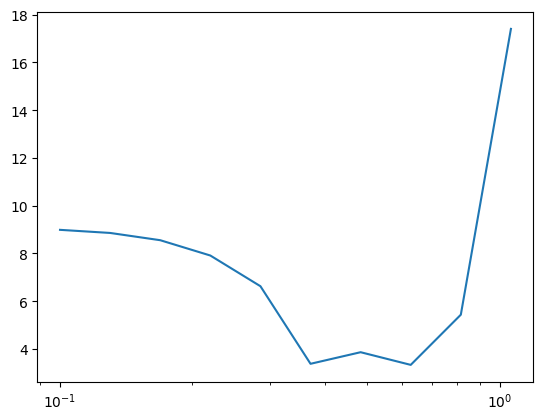

In [18]:
lrf_cbs = [DeviceCB(), ProgressCB(), LRFinderCB()]
learn = MomentumLearner(model, dls, F.cross_entropy, lr=1e-1, cbs=lrf_cbs)
learn.fit(1)

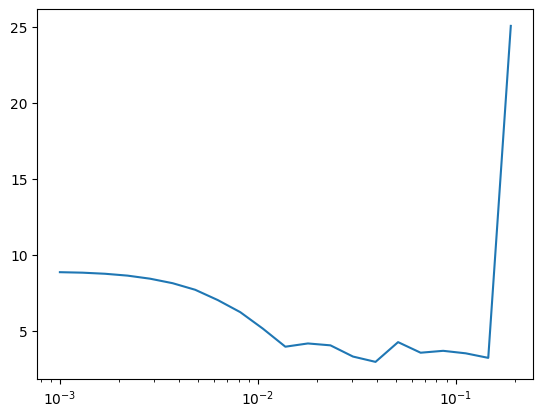

In [97]:
lrf_cbs = [DeviceCB(), ProgressCB(plot=True), LRFinderCB()]
learn = MomentumLearner(get_model().apply(init__weights), dls, F.cross_entropy, lr=1e-3, cbs=lrf_cbs)
learn.fit(1)

In [ ]:

# xl,yl = 'image','label'
# name = "fashion_mnist"
# dsd = load_dataset(name)

# @inplace
# def transformi(b): b[xl] = [TF.to_tensor(o) for o in b[xl]]

# bs = 1024
# tds = dsd.with_transform(transformi)

# dls = DataLoaders.from_dd(tds, bs, num_workers=4)

metrics = MetricsCB(accuracy=MulticlassAccuracy())
astats = ActivationStats(fc.risinstance(nn.ReLU))
cbs = [DeviceCB(device='cuda:0'), metrics, ProgressCB(plot=True), astats]

def get_model():
    return nn.Sequential(conv(1 ,8), conv(8 ,16), conv(16,32), conv(32,64),
                         conv(64,10, act=False), nn.Flatten()).to('cpu')
def init_weights(m):
    if isinstance(m, (nn.Conv1d,nn.Conv2d,nn.Conv3d, nn.Linear)): init.kaiming_normal_(m.weight)
     

set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.1, cbs=cbs)

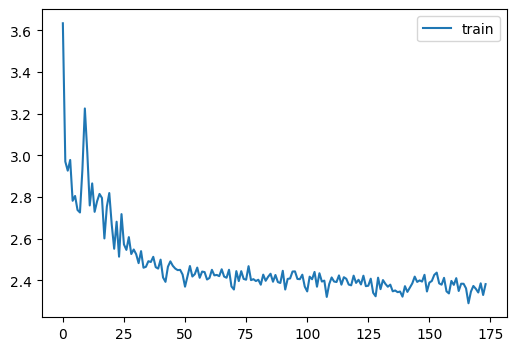

In [144]:
learn.fit(3)

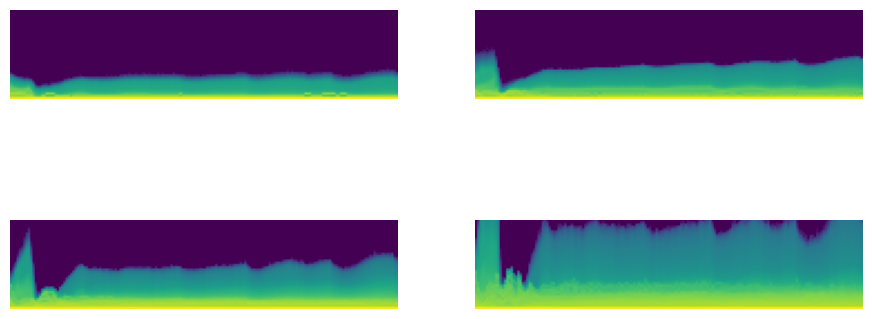

In [145]:
astats.color_dim()

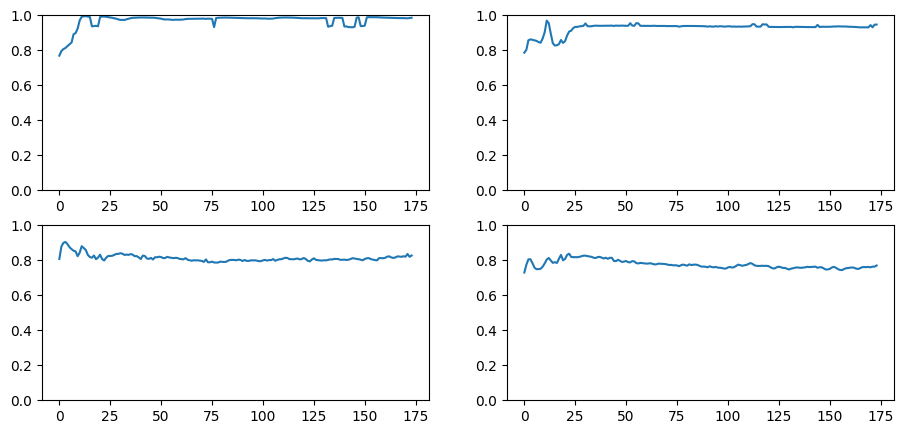

In [146]:
astats.dead_chart()

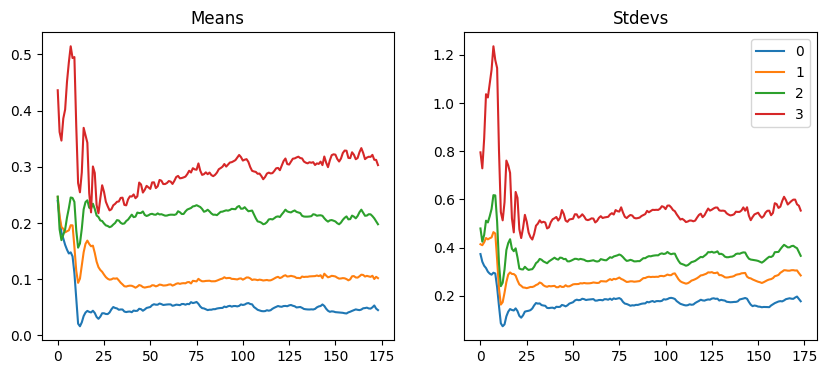

In [147]:
astats.plot_stats()

## Input normalisation

In [13]:
xb,yb = next(iter(dls.train))
xmean, xstd = xb.mean(), xb.std()
xmean, xstd

(tensor(0.28), tensor(0.35))

In [14]:
# export
class BatchTransformCB(Callback):
    def __init__(self, tfm): self.tfm = tfm
    def before_batch(self): self.learn.batch = self.tfm(self.learn.batch)

In [27]:
def _norm(b): return (b[0] - xmean) / xstd, b[1]
norm = BatchTransformCB(_norm)

In [26]:
def _norm(b): return (b[0] - b[0].mean()) / b[0].std(), b[1]
norm = BatchTransformCB(_norm)

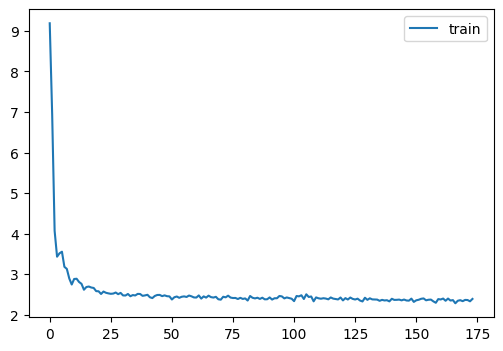

In [36]:
set_seed(42)
learn = MomentumLearner(get_model().apply(init_weights), dls, F.cross_entropy, lr=0.01, cbs=cbs+[norm])
learn.fit(3)

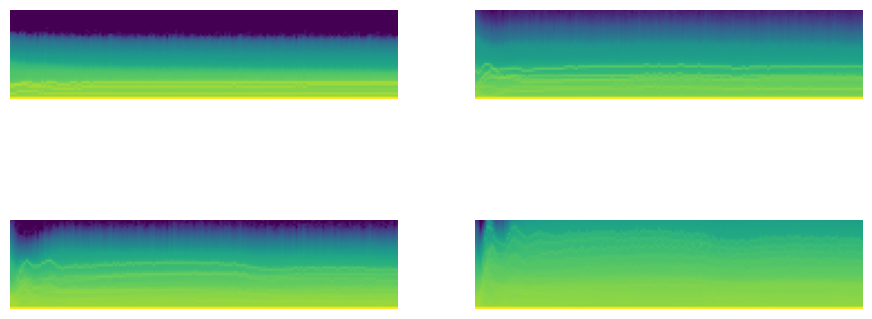

In [37]:
astats.color_dim()

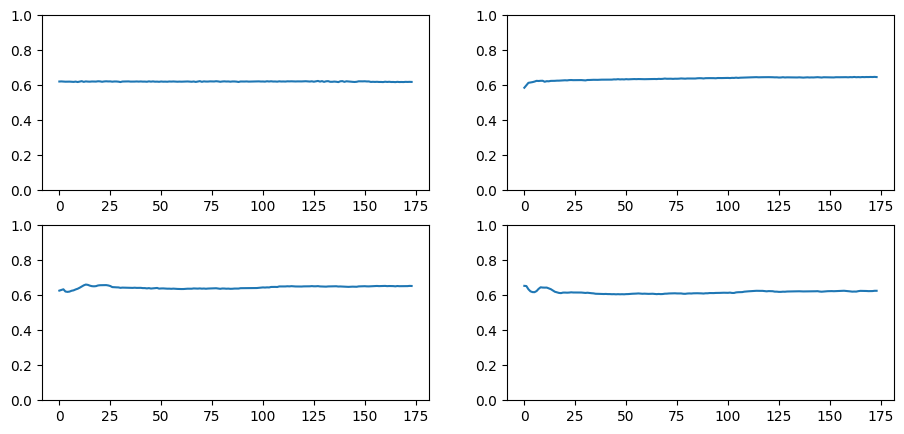

In [38]:
astats.dead_chart()

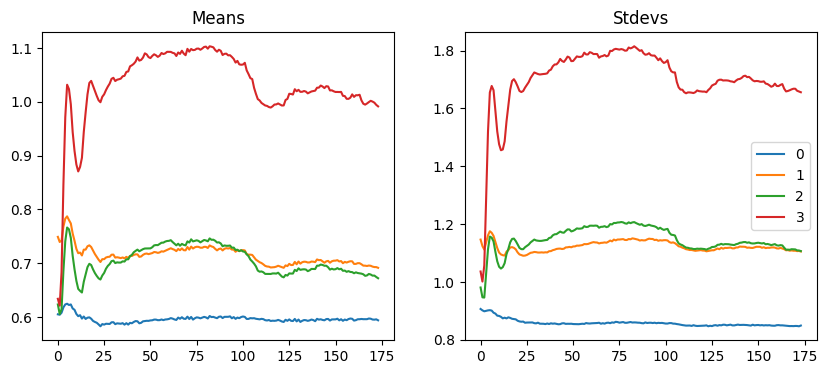

In [39]:
astats.plot_stats()

In [32]:
clean_mem()

In [17]:
@inplace
def transformi(b): b['image'] = [(TF.to_tensor(o)-xmean)/xstd for o in b['image']]
tds = dsd.with_transform(transformi)
dls = DataLoaders.from_dd(tds, bs, num_workers=2)
xb, yb = next(iter(dls.train))

In [18]:
xb.mean(), xb.std()

(tensor(    -0.00), tensor(1.))

# General ReLU

In [20]:
#export
class GeneralRelu(nn.Module):
    def __init__(self, leak=None, sub=None, maxv=None):
        super().__init__()
        self.leak, self.sub, self.maxv = leak, sub, maxv
    def forward(self, x):
        x = F.leaky_relu(x, self.leak) if self.leak is not None else F.relu(x)
        if self.sub is not None: x.sub_(self.sub)
        if self.maxv is not None: x.clamp_max_(self.maxv)
        return x

In [25]:
#export
def plot_func(f, start=-5., end=5., steps=100):
    x = torch.linspace(start, end, steps)
    plt.plot(x, f(x))
    plt.grid(True, which='both', ls='--')
    plt.axhline(y=0, color='k', linewidth=0.7)
    plt.axvline(x=0, color='k', linewidth=0.7)

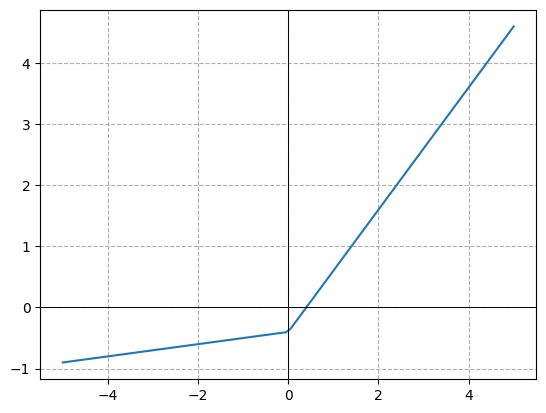

In [26]:
plot_func(GeneralRelu(leak=0.1, sub=0.4))

In [27]:
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU):
    res = nn.Conv2d(ni, nf, stride=stride, kernel_size=ks, padding=ks//2)
    if act: res = nn.Sequential(res, act())
    return res

In [29]:
def get_model(act=nn.ReLU, nfs=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None), nn.Flatten()).to('cuda:0')  

In [30]:
#export
def init_weights(m, leaky=0.):
    if isinstance(m, (nn.Conv1d, nn.Conv2d, nn.Conv3d, nn.Linear)): init.kaiming_normal_(m.weight, a=leaky)

In [33]:
act_gr = partial(GeneralRelu, leak=0.1, sub=0.4)
astats = ActivationStats(fc.risinstance(GeneralRelu))
cbs = [DeviceCB(device='cuda:0'), metrics, ProgressCB(plot=True), astats]
iw = partial(init_weights, leaky=0.1)

In [38]:
model = get_model(act_gr).apply(iw)

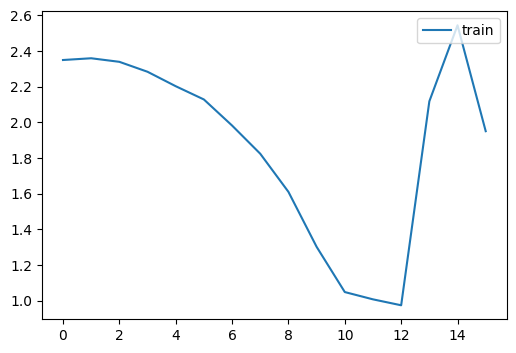

CancelFitException: 

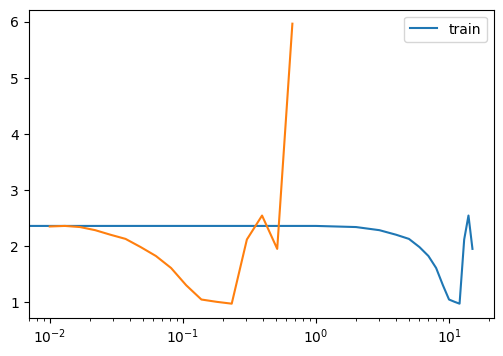

In [40]:
model = get_model(act_gr).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.01, cbs=cbs+[LRFinderCB()])
learn.fit(3)

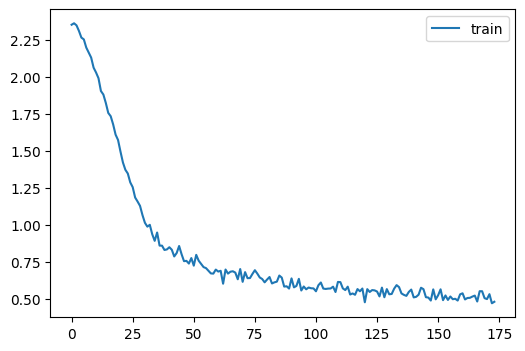

In [42]:
model = get_model(act_gr).apply(iw)
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.01, cbs=cbs)
learn.fit(3)

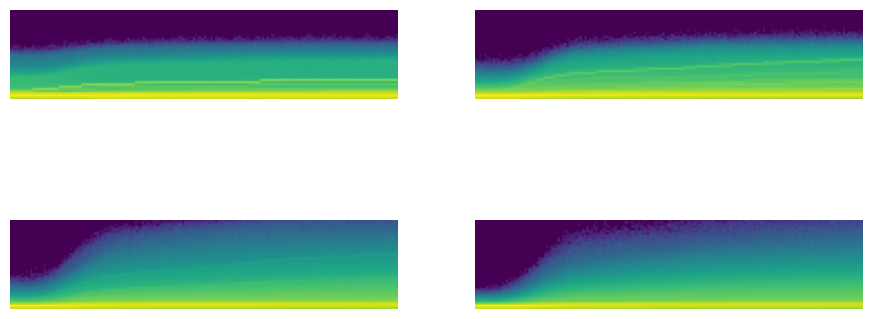

In [ ]:
astats.color_dim()

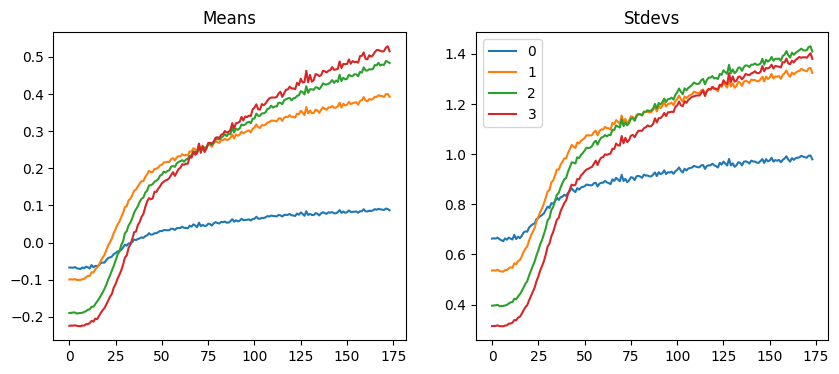

In [44]:
astats.plot_stats()

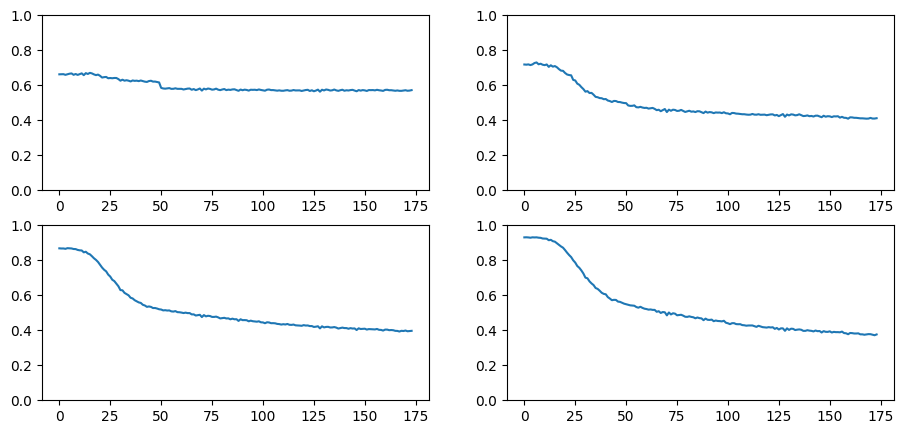

In [46]:
astats.dead_chart()

# LSUV

In [56]:
# export
def _lsuv_stats(hook, mod, inp, outp):
    acts = to_cpu(outp)
    hook.mean = acts.mean()
    hook.std = acts.std()
    
def lsuv_init(m, m_in, xb):
    h = Hook(m, _lsuv_stats)
    with torch.no_grad():
        while model(xb) is not None and (abs(h.std-1)>1e-3 or abs(h.mean)>1e-3):
            m_in.bias -= h.mean
            m_in.weight.data /= h.std
    h.remove()

In [57]:
model = get_model(act_gr)
relus = [o for o in model.modules() if isinstance(o, GeneralRelu)]
convs = [o for o in model.modules() if isinstance(o, nn.Conv2d)]

In [58]:
for ms in zip(relus, convs):print(ms)

(GeneralRelu(), Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))
(GeneralRelu(), Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)))


In [59]:
for ms in zip(relus, convs): lsuv_init(*ms, xb.to('cuda:0'))

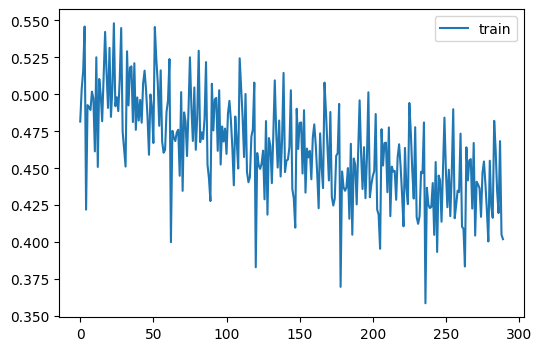

In [63]:
set_seed(42)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.005, cbs=cbs)
learn.fit(5)

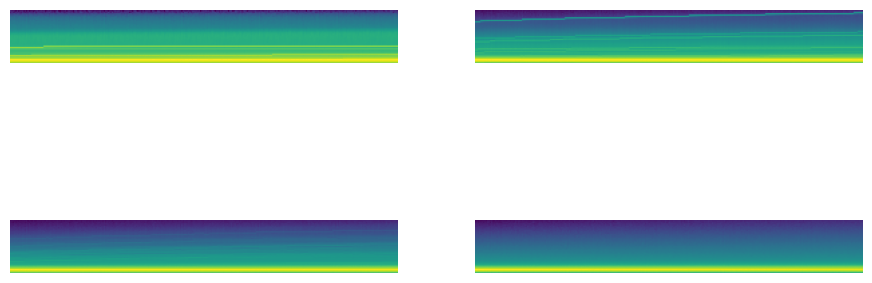

In [64]:
astats.color_dim()

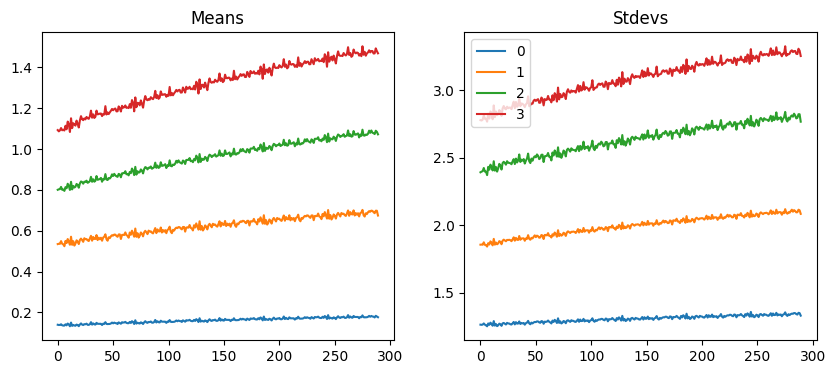

In [65]:
astats.plot_stats()

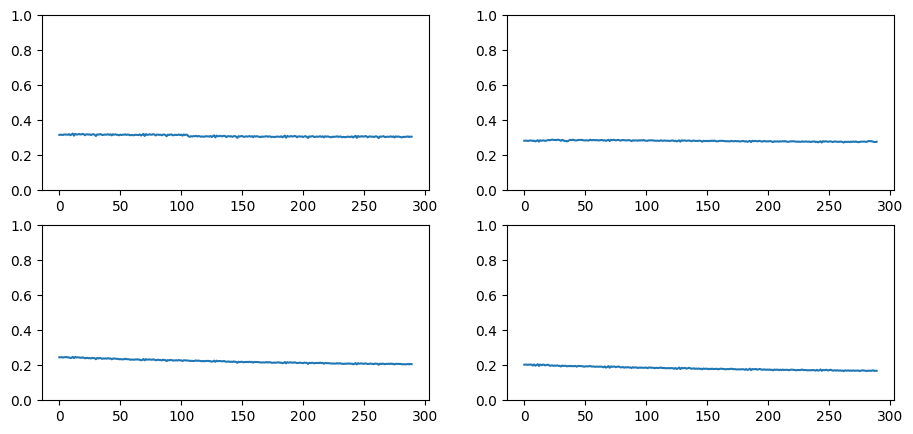

In [66]:
astats.dead_chart()

# BatchNormalisation

## laterNorm

In [86]:
class LayerNorm(nn.Module):
    def __init__(self, dummy, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.mult = nn.Parameter(tensor(1.))
        self.add = nn.Parameter(tensor(0.))
    def forward(self, x):
        m = x.mean((1,2,3), keepdim=True)
        v = x.var((1,2,3), keepdim=True)
        x = (x-m) / ((v + self.eps).sqrt())
        return x*self.mult + self.add

In [87]:
# export
def conv(ni, nf, ks=3, stride=2, act=nn.ReLU, norm=None, bias=False):
    layers = [nn.Conv2d(ni,nf, stride=stride, kernel_size=ks, padding=ks//2, bias=bias)]
    if norm: layers.append(norm(nf))
    if act: layers.append(act())
    return nn.Sequential(*layers)

In [88]:
# export
def get_model(act=nn.ReLU, nfs=None, norm=None):
    if nfs is None: nfs = [1,8,16,32,64]
    layers = [conv(nfs[i], nfs[i+1], act=act, norm=norm) for i in range(len(nfs)-1)]
    return nn.Sequential(*layers, conv(nfs[-1], 10, act=None, norm=None, bias=True), nn.Flatten()).to('cuda:0')

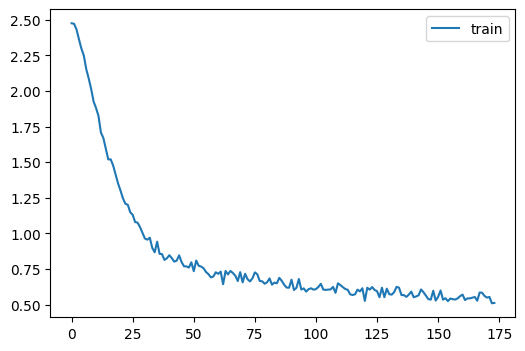

In [89]:
set_seed(42)
model = get_model(act_gr, norm=LayerNorm).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.005, cbs=cbs)
learn.fit(3)

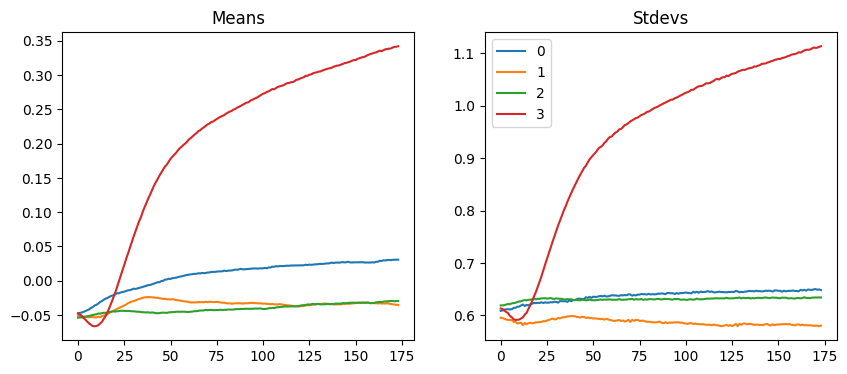

In [90]:
astats.plot_stats()

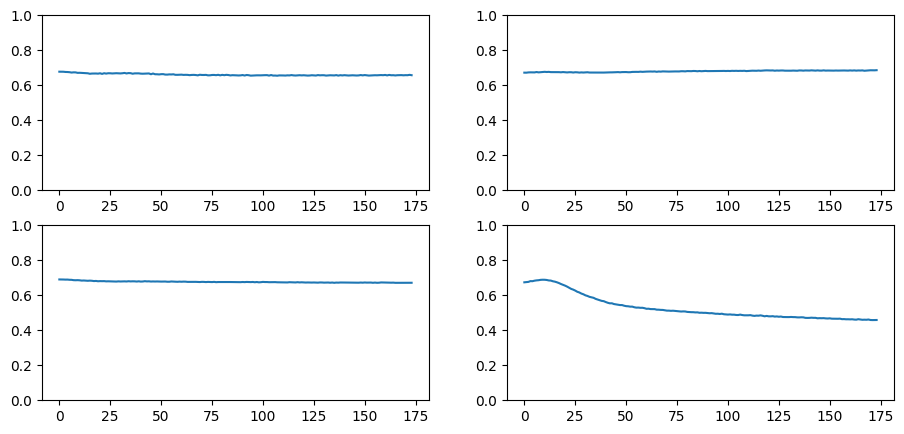

In [91]:
astats.dead_chart()

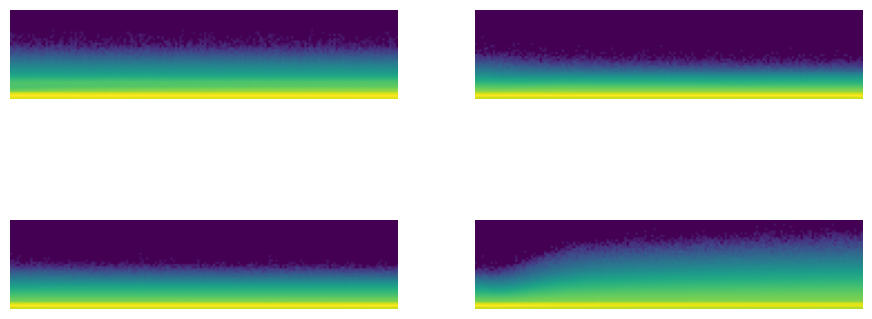

In [92]:
astats.color_dim()

## LayerNorm

In [113]:
class BatchNorm(nn.Module):
    def __init__(self, nf, mom=0.1, eps=1e-5):
        super().__init__()
        
        self.mom, self.eps = mom, eps
        self.mults = nn.Parameter(torch.ones(nf,1,1))
        self.adds = nn.Parameter(torch.zeros(nf,1,1))
        self.register_buffer('vars', torch.ones(1,nf,1,1))
        self.register_buffer('means', torch.zeros(1,nf,1,1))
    
    def update_stats(self, x):
        m = x.mean((0,2,3), keepdim=True)
        v = x.var((0,2,3), keepdim=True)
        self.means.lerp_(m, self.mom)
        self.vars.lerp_(m, self.mom)
        return m, v
    
    def forward(self, x):
        if self.training:
            with torch.no_grad(): m, v = self.update_stats(x)
        else: m, v = self.means, self.vars
        x = (x-m) / (v + self.eps).sqrt()
        return x*self.mults + self.adds

In [114]:
# del learn
# del model
clean_mem()

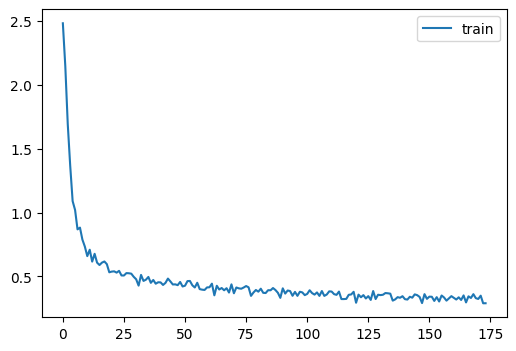

In [126]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(3)

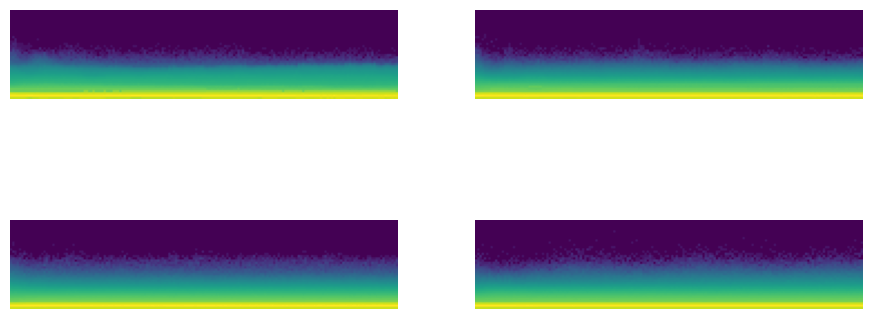

In [127]:
astats.color_dim()

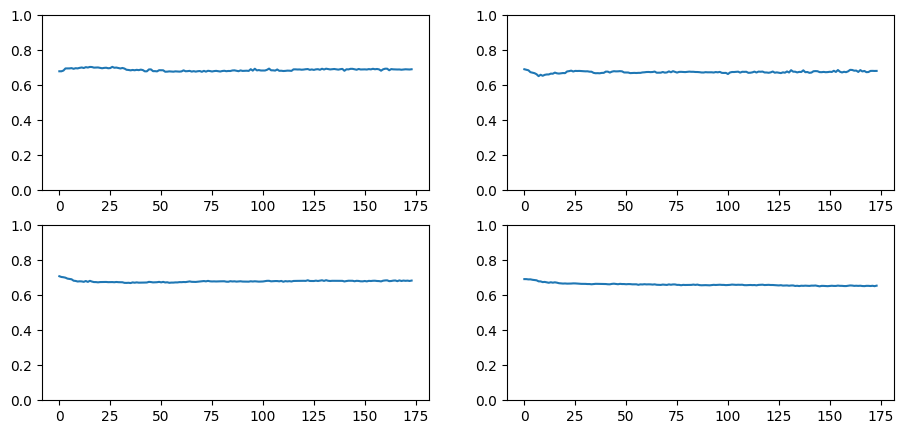

In [128]:
astats.dead_chart()

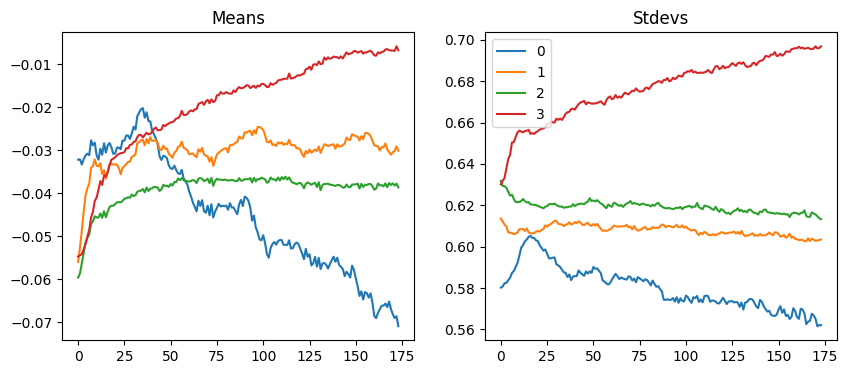

In [129]:
astats.plot_stats()

## towards 90%...

In [130]:
dls = DataLoaders.from_dd(tds, 256, num_workers=2)

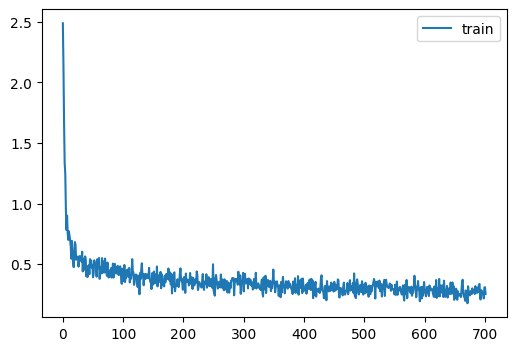

In [131]:
set_seed(42)
model = get_model(act_gr, norm=nn.BatchNorm2d).apply(iw)
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.1, cbs=cbs)
learn.fit(3)

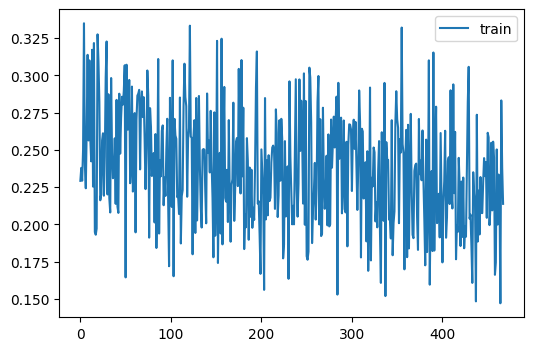

In [132]:
learn = MomentumLearner(model, dls, F.cross_entropy, lr=0.05, cbs=cbs)
learn.fit(2)